In [16]:
import random
from thesis.Aircraft import Aircraft
from thesis.Flight import Flight
from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario


from thesis.Trajectory import CircleTrajectory, BowtieTrajectory, SimpleLadderTrajectory

# These values are derived as described in the Trial 3 notebook
mass, wingSpan, e0, chord = 85.8526, 21.0000, 0.92, 1.0244

trajectories = {
  'circle': CircleTrajectory((0, 0, 1000), 1972.03),
  'bowtie': BowtieTrajectory((0, 0, 1000), lobeRadius = 500, lobeCenterDistance = 1476.23),
  'ladder': SimpleLadderTrajectory(
    (0, 0, 1000),
    lobeRadius = 500,
    lobeCenterDistance = 1475.45,
    stepHeight=60,
    nSteps=36,
    nStepsDown=55
  )
}

# Our modelled aircraft
craft = Aircraft(mass = mass, wingSpan = wingSpan, e0 = e0, chord = chord)

# From NS3 defaults
radioParams = {
  'xmitPower': 30, # dBm
  'B': 180e3 * 25, # 25 180kHz RBs = 4.5 MHz
  'N0': -174       # See lte-spectrum-value-helper.cc kT_dBm_Hz
}

def makeFlight(traj):
    trajectory = trajectories[traj]
    return Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

In [17]:
plt.style.available

['Solarize_Light2',
 'tableau-colorblind10',
 'seaborn-dark-palette',
 'grayscale',
 'fivethirtyeight',
 'seaborn-muted',
 'seaborn-white',
 'seaborn-pastel',
 'seaborn-colorblind',
 'classic',
 'ggplot',
 'seaborn-dark',
 'seaborn-deep',
 'seaborn-paper',
 'seaborn-ticks',
 'seaborn-bright',
 'seaborn-talk',
 'seaborn-whitegrid',
 'seaborn-darkgrid',
 'seaborn-poster',
 'seaborn-notebook',
 'seaborn',
 'fast',
 '_classic_test',
 'dark_background',
 'bmh']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size':12})
plt.rcParams.update({'font.size':16})
plt.rcParams.update({'text.usetex':True})


def mkPathPacked(name, trajectory, run, users, radius):
    return './packed/%s_%s_run%d_usr%d_rad%.2f.parquet.gzip' % (name, trajectory, run, users, radius)

dlSinr = pd.read_parquet(mkPathPacked('dlSinr', 'ladder', 1, 5, 5), engine='fastparquet')

FileNotFoundError: [Errno 2] No such file or directory: './packed/dlSinr_ladder_run1_usr5_rad5.00.parquet.gzip'

Text(0.5, 1.0, 'SINR over time (ladder)')

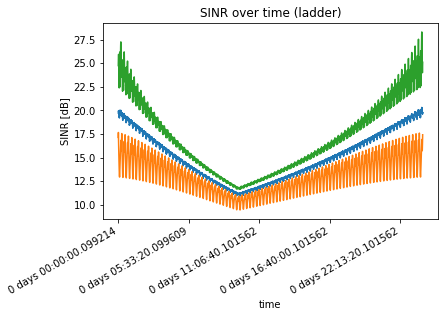

In [22]:
dlSinr.sinr.rolling(200L, center=True).mean().plot()
dlSinr.sinr.rolling(200L, center=True).min().plot()
dlSinr.sinr.rolling(200L, center=True).max().plot()
plt.ylabel('SINR [dB]')
plt.title('SINR over time (ladder)')

In [ ]:
dlSinr.index = pd.to_timedelta(dlSinr.index, 's')

In [ ]:
# Note, have to exclude the last time slot or it includes artifacts from the simulation end
dlSinr.sinr.resample('15min', closed='right').aggregate([np.min, np.mean, np.max])[:'23h45min'].plot(figsize=(18,10))

In [ ]:
for run in range(10):
    dlSinr = pd.read_parquet(mkPathPacked('dlSinr', 'ladder', run, 5, 5))
    dlSinr.index = pd.to_timedelta(dlSinr.index, 's')
    dlSinr.sinr.resample('15min', closed='right').aggregate(np.mean)[:'23h45min'].plot(figsize=(18,10))

In [10]:
asrv = pd.read_parquet(mkPathPacked('serverStats', 'ladder', 5, 5, 5), engine='fastparquet')
bsrv = pd.read_parquet(mkPathPacked('serverStats', 'ladder', 6, 5, 5), engine='fastparquet')

acln = pd.read_parquet(mkPathPacked('clientStats', 'ladder', 5, 5, 5), engine='fastparquet')
bcln = pd.read_parquet(mkPathPacked('clientStats', 'ladder', 6, 5, 5), engine='fastparquet')
a

NameError: name 'mkPathPacked' is not defined

In [2]:
def loadAll(traj, runs, usr=5, rad=5, freq = '30min'):
    def load(run):
        srv = pd.read_parquet(mkPathPacked('serverStats', traj, run, usr, rad), engine='fastparquet')
        cln = pd.read_parquet(mkPathPacked('clientStats', traj, run, usr, rad), engine='fastparquet')

        # Number of bytes received / number of bytes sent, grouped/smoothed into 10 minute buckets, averaged over each user
        return (srv / cln).groupby([pd.Grouper(freq=freq, level='time'), 'flowId']).mean().mean(level='time')


    frame = load(runs[0])
    for i in runs[1:]:
        frame = frame.merge(load(i), on='time', suffixes=['_%d' % (i - 1), '_%d' % i])
        
    return frame

def loadSend(traj, runs, usr=5, rad=5, freq = '30min'):
    def load(run):
        #srv = pd.read_parquet(mkPathPacked('serverStats', traj, run, usr, rad), engine='fastparquet')
        cln = pd.read_parquet(mkPathPacked('clientStats', traj, run, usr, rad), engine='fastparquet')

        # Number of bytes received / number of bytes sent, grouped/smoothed into 10 minute buckets, averaged over each user
        return cln.groupby([pd.Grouper(freq=freq, level='time'), 'flowId']).sum().sum(level='time')


    frame = load(runs[0])
    for i in runs[1:]:
        frame = frame.merge(load(i), on='time', suffixes=['_%d' % (i - 1), '_%d' % i])
        
    # Divide into per-second values
    frame /= pd.to_timedelta(freq).total_seconds()
        
    return frame

def loadReceive(traj, runs, usr=5, rad=5, freq = '30min'):
    def load(run):
        srv = pd.read_parquet(mkPathPacked('serverStats', traj, run, usr, rad), engine='fastparquet')
        #cln = pd.read_parquet(mkPathPacked('clientStats', traj, run, usr, rad), engine='fastparquet')

        # Number of bytes received / number of bytes sent, grouped/smoothed into 10 minute buckets, averaged over each user
        return srv.groupby([pd.Grouper(freq=freq, level='time'), 'flowId']).sum().sum(level='time')


    frame = load(runs[0])
    for i in runs[1:]:
        frame = frame.merge(load(i), on='time', suffixes=['_%d' % (i - 1), '_%d' % i])
        
    # Divide into per-second values
    frame /= pd.to_timedelta(freq).total_seconds()
        
    return frame

In [3]:
# frame = pd.read_parquet(mkPathPacked('clientStats', 'circle', 0, 5, 5), engine='fastparquet')
# frame.groupby([pd.Grouper(freq='30min', level='time'), 'flowId']).sum().sum(level='time') / 1e6 / 30 / 60 * 8

loadReceive('circle', range(10)) * 8 / 1e6

,bytes_0,bytes_1,bytes_2,bytes_3,bytes_4,bytes_5,bytes_6,bytes_7,bytes_8,bytes_9
time,,,,,,,,,,
0 days 00:00:00,8.442511,8.409112,8.413901,8.514253,8.352161,8.424341,8.423165,8.331052,8.441413,8.464476
0 days 00:30:00,8.694560,8.598167,8.506465,8.482887,8.471505,8.554662,8.672216,8.539472,8.520911,8.440524
0 days 01:00:00,8.641013,8.523472,8.540974,8.636773,8.540602,8.558301,8.497704,8.448332,8.457733,8.462881
0 days 01:30:00,8.520982,8.759919,8.551767,8.558451,8.639994,8.537022,8.650127,8.562574,8.729762,8.512293
0 days 02:00:00,8.452226,8.716682,8.447090,8.614011,8.575294,8.569368,8.526431,8.534872,8.394798,8.545985
0 days 02:30:00,8.389342,8.666408,8.485493,8.542444,8.564102,8.515795,8.534500,8.578267,8.412353,8.556870
0 days 03:00:00,8.450579,8.704216,8.629893,8.663213,8.624176,8.694906,8.720347,8.582193,8.715160,8.517278
0 days 03:30:00,8.347692,8.560195,8.443327,8.490883,8.560189,8.750734,8.552983,8.630769,8.517931,8.486388
0 days 04:00:00,8.439290,8.554577,8.480025,8.512842,8.537727,8.546214,8.874730,8.662834,8.705902,8.725430


In [4]:
def ourPlot(traj, loader = loadAll, label = None, multiplier = 1, ax=None, **kwargs):
    import matplotlib.ticker as mtick
    
    frame = loader(traj, range(30))
    # Starting time of our trajectory durations, so we have a proper alignment of the plots
    frame.index += pd.to_datetime('2020-11-28T08')
    
    # Plot the mean (over all runs)
    curve = frame.mean(axis=1)
    curve *= multiplier
    if ax is None:
        ax2 = ax = curve.plot(ax=ax, label=label, **kwargs)
    else:
        ax2 = ax.plot(curve, label=label, **kwargs)
    
    # Plot all of the runs (noisy)
    #frame.plot(style=':', legend=False, linewidth=1, ax=ax)
    
    # Plot the +/- 2σ region (reasonable clear)
    # I'm not sure if this is how stdev works...
    mstd = (frame * multiplier).std(axis=1)
    ma = (frame * multiplier).mean(axis=1)
    fill_args = kwargs.copy()
    if 'linestyle' in fill_args:
        del fill_args['linestyle']
    ax.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, alpha=0.2, **fill_args)

    
    
    #plt.title('Percent of bytes delivered (+- 2σ)')
    if loader == loadAll:
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    else:
        ax.set_ylim(0)
    
    print('%s: min %.2f max %.2f avg %.2f' % (traj, curve.min(), curve.max(), curve.mean()))
    
    return ax

circle: min 12.69 max 13.28 avg 13.05
circle: min 8.42 max 8.63 avg 8.56
bowtie: min 8.91 max 9.03 avg 8.98
ladder: min 3.92 max 8.87 avg 6.13


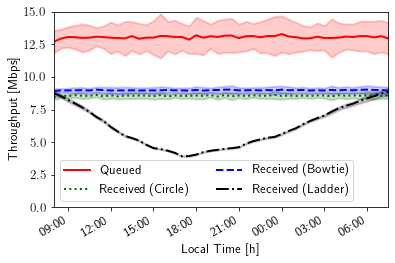

In [14]:
#fig = plt.figure(figsize=(18,10))
#subs = fig.subplots(1,3)
#fig.suptitle('Percentage of queued bytes delivered +- 2σ')

plt.rcParams.update({'font.size':13})
plt.rcParams.update({'text.usetex':True})

fig, ax1 = plt.subplots()
ourPlot('circle', loader=loadSend, multiplier=8 / 1e6, color='red', ax=ax1, linewidth=2)
ourPlot('circle', loader=loadReceive, multiplier=8/1e6, color='darkgreen', linestyle=':', linewidth=2)

plt.ylabel('Throughput [Mbps]')

#plt.figure(); ourPlot('bowtie', loader=loadSend, multiplier=8 / 1e6, color='red', linestyle=':')
ourPlot('bowtie', loader=loadReceive, multiplier=8/1e6, color='blue', linestyle='--', linewidth=2)

#plt.figure(); ourPlot('ladder', loader=loadSend, multiplier=8 / 1e6, color='red', linestyle=':')
ourPlot('ladder', loader=loadReceive, multiplier=8/1e6, color='black', linestyle='-.', linewidth=2)
plt.legend(['Queued', 'Received (Circle)', 'Received (Bowtie)', 'Received (Ladder)'], ncol=2, borderpad=0.3)

from matplotlib.dates import DateFormatter
ax1.set_xlabel('Local Time [h]')
times = loadReceive('circle', range(10)).index + pd.to_datetime('2020-11-28T08')
ax1.xaxis.set_major_formatter(DateFormatter('%H:%M', tz=times.tz))

# Plot the altitude as well, might be helpful
# from thesis.Aircraft import Aircraft
# from thesis.Trajectory import SimpleLadderTrajectory
# from thesis.Flight import Flight
# craft = Aircraft(mass = mass, wingSpan = wingSpan, e0 = e0, chord = chord)
# traj = SimpleLadderTrajectory(
#     (0, 0, 1000),
#     lobeRadius = 500,
#     lobeCenterDistance = 1475.45,
#     stepHeight=60,
#     nSteps=36,
#     nStepsDown=55
# )
# flight = Flight(craft, traj, [5 for piece in traj.pieces])
# times = loadSend('ladder', range(1)).index + pd.to_datetime('2020-11-28T08')
# poses = flight.toPoses(times.to_series())
# ax2 = plt.twinx()
# ax2.set_ylabel('Altitude [m]')
# ax2.set_ylim(0, 10000)
# poses.z.plot(color='black', marker='+')
# plt.legend(['Altitude'])

# Tidy up x axis margins
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('appthru_combined_absolute.pdf')

2020-11-29 07:30:00


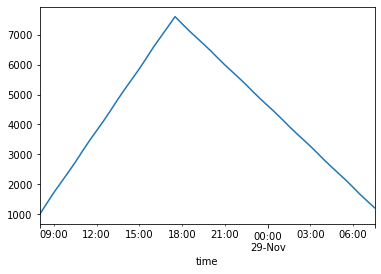

In [474]:
from thesis.Aircraft import Aircraft
from thesis.Trajectory import SimpleLadderTrajectory
from thesis.Flight import Flight
craft = Aircraft(mass = mass, wingSpan = wingSpan, e0 = e0, chord = chord)
traj = SimpleLadderTrajectory(
    (0, 0, 1000),
    lobeRadius = 500,
    lobeCenterDistance = 1475.45,
    stepHeight=60,
    nSteps=36,
    nStepsDown=55
)
flight = Flight(craft, traj, [5 for piece in traj.pieces])
times = loadSend('ladder', range(1)).index + pd.to_datetime('2020-11-28T08')
poses = flight.toPoses(times.to_series())
poses.z.plot()

In [446]:
srv = pd.read_parquet(mkPathPacked('serverStats', 'circle', 0, 5, 5), engine='fastparquet')
bytesPerMinutePerUE = srv.groupby([pd.Grouper(freq='1min', level='time'), 'flowId']).sum()
MbpsPerUe = bytesPerMinutePerUE * 8 / 1e6 / 60

MbpsPerUe.sum(level='time')

,bytes
time,
0 days 00:00:00,8.325100
0 days 00:01:00,8.198680
0 days 00:02:00,7.890568
0 days 00:03:00,8.143408
0 days 00:04:00,8.351168
...,...
0 days 23:55:00,8.526000
0 days 23:56:00,8.324120
0 days 23:57:00,8.830976


circle: min 0.66 max 0.69 avg 0.68
bowtie: min 0.69 max 0.72 avg 0.70
ladder: min 0.34 max 0.71 avg 0.50


<Figure size 432x288 with 0 Axes>

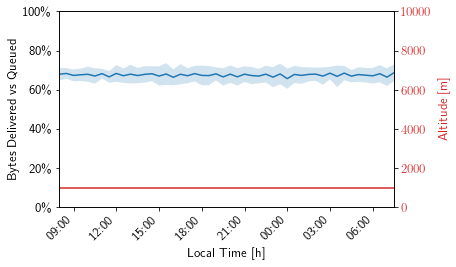

<Figure size 432x288 with 0 Axes>

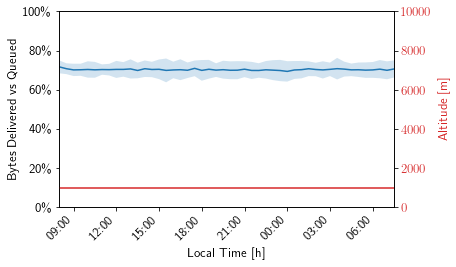

<Figure size 432x288 with 0 Axes>

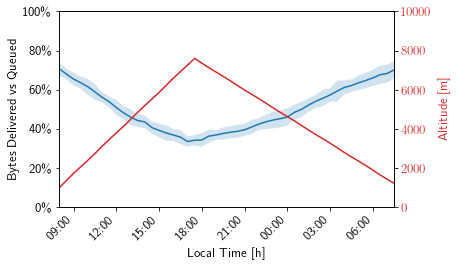

In [17]:
def augmentedPlot(traj):
    fig, ax = plt.subplots()
    
    ourPlot(traj, ax=ax)
    ax.set_ylabel('Bytes Delivered vs Queued')

    ax2 = ax.twinx()
    ax2.set_ylabel('Altitude [m]', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 10000)
    times_frame = loadAll(traj, range(1)).index + pd.to_datetime('20201128T08')
    times = times_frame.to_series()
    ax2.plot(makeFlight(traj).toPoses(times).z, color='tab:red')
    
    from matplotlib.dates import DateFormatter
    ax.set_xlabel('Local Time [h]')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M', tz=times_frame.tz))
    
    # Tidy up x axis margins
    plt.autoscale(enable=True, axis='x', tight=True)
    
    fig.autofmt_xdate(rotation=45)
    
    
    
plt.figure(); augmentedPlot('circle')
plt.figure(); augmentedPlot('bowtie')
plt.figure(); augmentedPlot('ladder')


ladder: min 3.92 max 8.87 avg 6.13


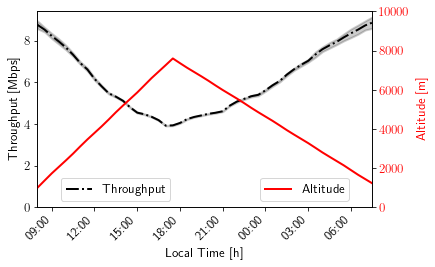

In [18]:
# Those really aren't that impressive, this is probably more concise
fig, ax = plt.subplots()

ourPlot('ladder', loader=loadReceive, multiplier=8/1e6, color='black', linestyle='-.', ax=ax, linewidth=2)
ax.set_ylabel('Throughput [Mbps]')
plt.legend(['Throughput'], loc='lower left', bbox_to_anchor=(0.05, 0))

ax2 = ax.twinx()
ax2.set_ylabel('Altitude [m]', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 10000)
times_frame = loadAll('ladder', range(1)).index + pd.to_datetime('20201128T08')
times = times_frame.to_series()
ax2.plot(makeFlight('ladder').toPoses(times).z, color='red', linewidth=2)

from matplotlib.dates import DateFormatter
ax.set_xlabel('Local Time [h]')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M', tz=times_frame.tz))
fig.autofmt_xdate(rotation=45)

# Tidy up x axis margins
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(['Altitude'], loc='lower right', bbox_to_anchor=(0.95, 0))


plt.savefig('appthru_ladder_altitude.pdf', bbox_inches = 'tight')

TypeError: cannot add DatetimeArray and Timestamp

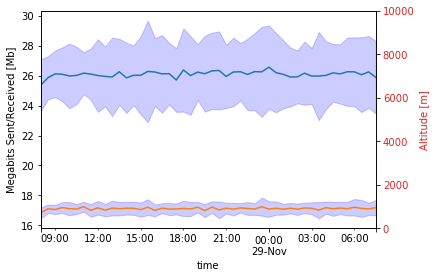

In [382]:
def plotSendReceive(traj, ax=None, **kwargs):
    import matplotlib.ticker as mtick
    
    send = loadSend(traj, range(30))
    recv = loadReceive(traj, range(30))
    
    # Convert to Mb
    send *= 8 / 1e6
    recv *= 8 / 1e6
    
    # Starting time of our trajectory durations, so we have a proper alignment of the plots
    send.index += pd.to_datetime('2020-11-28T08')
    recv.index += pd.to_datetime('2020-11-28T08')
    
    # Plot the mean (over all runs)
    ax2 = send.mean(axis=1).plot(ax=ax)
    ax2 = recv.mean(axis=1).plot(ax=ax)
    
    if ax is None: ax = ax2
    
    # Plot the +/- 2σ region (reasonable clear)
    mstd = send.std(axis=1)
    ma = send.mean(axis=1)
    ax.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="b", alpha=0.2)
    
    mstd = recv.std(axis=1)
    ma = recv.mean(axis=1)
    ax.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="b", alpha=0.2)

    
    
    #plt.title('Percent of bytes delivered (+- 2σ)')
    #ax.set_ylim(0, 1)
    
    ax.set_ylabel('Megabits Sent/Received [Mb]')

    ax2 = ax.twinx()
    ax2.set_ylabel('Altitude [m]', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 10000)
    times = (frame.index + pd.to_datetime('20201128T08')).to_series()
    makeFlight(traj).toPoses(times).z.plot(color='tab:red')
    
    
    return ax

plotSendReceive('circle')

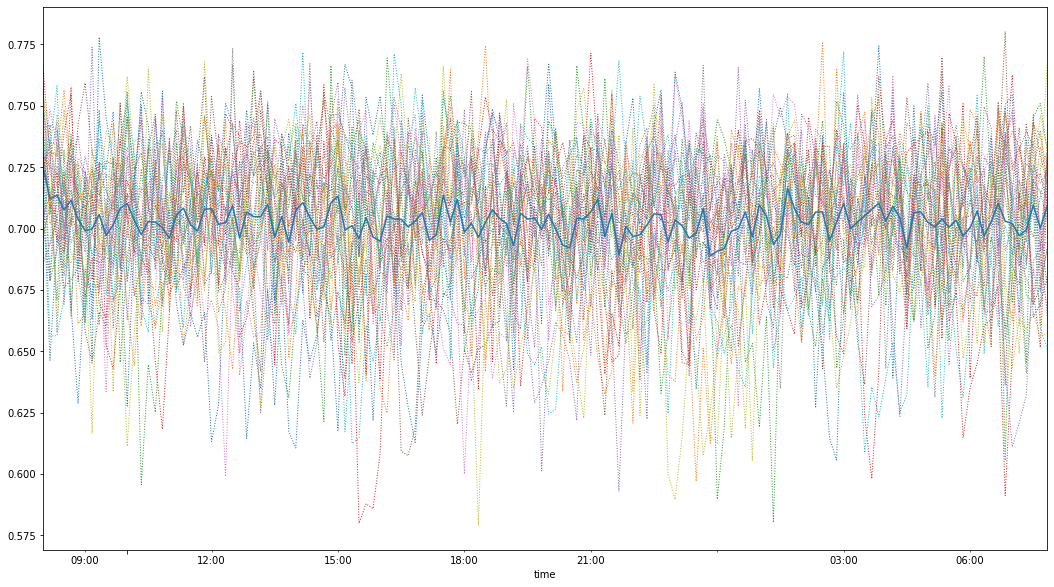

In [251]:
frame.plot(style=':', legend=False, linewidth=1)
frame.mean(axis=1).plot(figsize=(18,10), xticks=[pd.to_datetime('2020-11-28T10')])

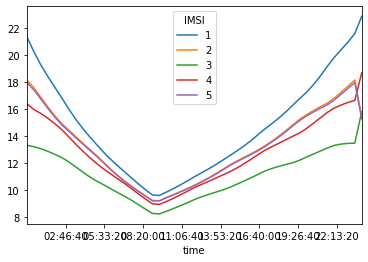

In [351]:
d=pd.read_parquet(mkPathPacked('ulSinr', 'ladder', 0, 5, 5), engine='fastparquet')
#d.pivot_table(values='sinr', index=d.index,columns='IMSI',aggfunc='first').plot()
d.groupby([pd.Grouper(freq='30min', level='time'), 'IMSI']).mean().sinr.unstack().plot()